# ETHZ: 227-0966-00L
# Quantitative Big Imaging
# March 12, 2020

## Basic Segmentation and Discrete Binary Structures
### Part 1

### Anders Kaestner

# Lesson Outline
- Motivation
- Qualitative Approaches
- Thresholding
 - Other types of images
 - Selecting a good threshold
- Implementation
- Morphology
- Contouring / Mask Creation

### Applications

<table>
    <tr>
        <td>
        
- Simple two-phase materials (bone, cells, etc)
  - Beyond 1 channel of depth
- Multiple phase materials
- Filling holes in materials
- Segmenting Fossils
- Attempting to segment the cortex in brain imaging

</td>
<td>
<figure>
    
![Cortex Image](ext-figures/cortex.png)
        <figcaption>The cortex in brain imaging</figcaption>
</figure>
</td></tr></table>

# Literature / Useful References

- John C. Russ, “The Image Processing Handbook”,(Boca Raton, CRC Press)
 - Available [online](http://dx.doi.org/10.1201/9780203881095) within domain ethz.ch (or proxy.ethz.ch / public VPN) 

### Models / ROC Curves

- [Julia Evans - Recalling with Precision](https://www.youtube.com/watch?v=ryZL4XNUmwo)
- [Stripe's Next Top Model](https://github.com/stripe/topmodel)

# Motivation:  Why do we do imaging experiments?

## Exploratory
 - To visually, qualitatively examine samples and differences between them
 - No prior knowledge or expectations
 
## To test a hypothesis
Quantitative assessment coupled with statistical analysis
 - Does temperature affect bubble size?
 - Is this gene important for cell shape and thus mechanosensation in bone?
 - Does higher canal volume make bones weaker?
 - Does the granule shape affect battery life expectancy?

## What we are looking at?
![Standard Cell, http://en.wikipedia.org/wiki/File:Average_prokaryote_cell-_en.svg](ext-figures/Average_prokaryote_cell.svg) 

## What we get from the imaging modality

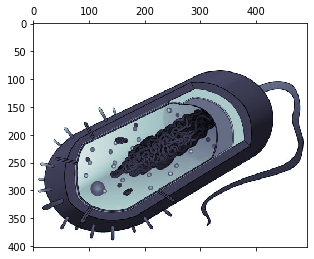

In [1]:
%matplotlib inline
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
dkimg = imread("../common/figures/Average_prokaryote_cell.jpg")
plt.matshow(rgb2gray(dkimg), cmap = 'bone')

# To test a hypothesis

We perform an experiment bone to see how big the cells are inside the tissue:

    
$$\downarrow$$ 
    
<img src="ext-figures/tomoimage.png" style="height:200px"> 

### <center>2560 x 2560 x 2160 x 32 bit = 56GB / sample</center>
    
<center>Filtering and Preprocessing!  </center>
    
$$\downarrow$$

### <center>20h of computer time later ...</center>

<center>Still 56GB of data, but less noisy</center>

<div class="alert alert-block alert-warning">
<center>
    
### Way too much data, we need to reduce
    
</center>
</div>



# What did we want in the first place?


### *Single numbers*:
* volume fraction,
* cell count,
* average cell stretch,
* cell volume variability

# Why do we perform segmentation?

- In model-based analysis every step we peform, simple or complicated is related to an underlying model of the system we are dealing with
- [_Occam's Razor_](http://en.wikipedia.org/wiki/Occams_Razor) is very important here : The simplest solution is usually the right one
 - Bayesian, neural networks optimized using genetic algorithms with Fuzzy logic has a much larger parameter space to explore, establish sensitivity in, and must perform much better and be tested much more thoroughly than thresholding to be justified.
 - We will cover some of these techniques in the next 2 lectures since they can be very powerful particularly with unknown data

# Review: Filtering and Image Enhancement (last week)


This was a noise process which was added to otherwise clean imaging data

<center><img src="ext-figures/lecture03/imperfect_imaging_system.svg" style="height:150px" align="middle"></center>

$$ I_{measured}(x,y) = I_{sample}(x,y) + \text{Noise}(x,y) $$

- What would the perfect filter be

$$ \textit{Filter} \ast I_{sample}(x,y) = I_{sample}(x,y) $$
 $$ \textit{Filter} \ast \text{Noise}(x,y) = 0 $$ 
 $$ \textit{Filter} \ast I_{measured}(x,y) = \textit{Filter} \ast I_{real}(x,y) + \textit{Filter}\ast \text{Noise}(x,y) \rightarrow \bf I_{sample}(x,y) $$



<div class="alert alert-block alert-success">

What __most filters__ end up doing
$$ \textit{Filter} \ast I_{measured}(x,y) = 90\%  I_{real}(x,y) + 10\% \text{Noise}(x,y) $$
    
</div> 


<div class="alert alert-block alert-danger">

What __bad filters__ do
$$ \textit{Filter} \ast I_{measured}(x,y) = 10\% I_{real}(x,y) + 90\% \text{Noise}(x,y) $$
    
</div> 


# Qualitative Metrics: What did people use to do?
- What comes out of our detector / enhancement process 

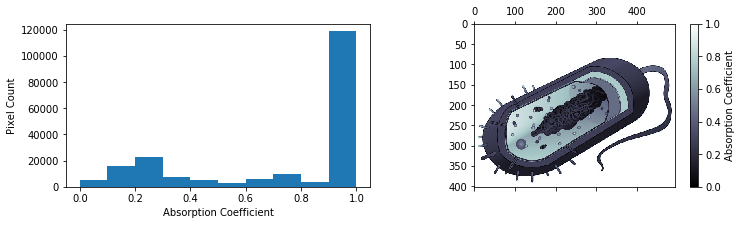

In [2]:
%matplotlib inline
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
dkimg = rgb2gray(imread("../common/figures/Average_prokaryote_cell.jpg"))
fig, (ax_hist, ax_img) = plt.subplots(1, 2, figsize = (12,3))

ax_hist.hist(dkimg.ravel())
ax_hist.set_xlabel('Absorption Coefficient')
ax_hist.set_ylabel('Pixel Count')

m_show_obj = ax_img.matshow(dkimg, cmap = 'bone')
cb_obj = plt.colorbar(m_show_obj)
cb_obj.set_label('Absorption Coefficient')

### Identify objects by eye
 - Count, describe qualitatively: "many little cilia on surface", "long curly flaggelum", "elongated nuclear structure"
 
### Morphometrics
 - Trace the outline of the object (or sub-structures)
 - Can calculate the area by using equal-weight-paper 
 - Employing the "[cut-and-weigh](http://ion.chem.usu.edu/~sbialkow/Classes/361/GC/GC.html)" method


# Segmentation Approaches


They match up well to the world view / perspective 

![Approaches](../common/figures/approaches.png)

## Segmentation approaches

<table>
<tr><th>
Model-Based        
</th>
<th>
Machine Learning Approach  
</th></tr>
<tr><td>    
Experimentalist   
</td>
<td>
Computer Vision / Deep Learning    
</td></tr>    
<tr><td valign="top">
    
Problem-driven
 - Top-down
 - _Reality_ Model-based    

</td><td valign="top">
Results-driven    
</td></tr>    
</table>

# Model-based Analysis

![Traditional Imaging](../common/figures/image-formation.png)

- Many different imaging modalities <br/>( $\mu \textrm{CT}$ to MRI to Confocal to Light-field to AFM). 
- Similarities in underlying equations
 - different coefficients, units, and mechanism

$$ I_{measured}(\vec{x}) = F_{system}(I_{stimulus}(\vec{x}),S_{sample}(\vec{x})) $$

# Direct Imaging (simple)

In many setups there is un-even illumination caused by incorrectly adjusted equipment and fluctations in power and setups

$$\begin{eqnarray}
F_{system}(a,b) &=& a*b \\
I_{stimulus} &=& \textrm{Beam}_{profile} \\
S_{system} &=&\alpha(\vec{x}) \\
\longrightarrow \alpha(\vec{x})&=&\frac{I_{measured}(\vec{x})}{\textrm{Beam}_{profile}(\vec{x})}
\end{eqnarray}$$






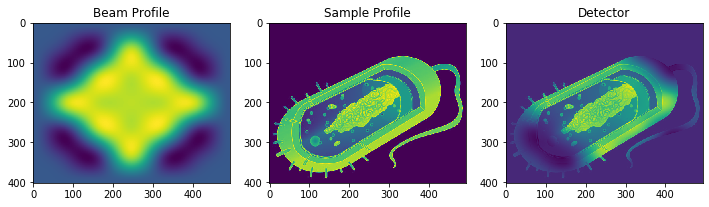

In [3]:
%matplotlib inline
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.morphology import disk
from scipy.ndimage import zoom
import numpy as np

cell_img = 1-rgb2gray(imread("../common/figures/Average_prokaryote_cell.jpg"))
s_beam_img = np.pad(disk(2)/1.0, [[1,1], [1,1]], mode = 'constant', constant_values = 0.2)
beam_img = zoom(s_beam_img, 
                [cell_img.shape[0]/7.0, cell_img.shape[1]/7.0])

fig, (ax_beam, ax_img, ax_det) = plt.subplots(1, 3, figsize = (12,4))

ax_beam.imshow(beam_img, 
               cmap = 'viridis')
ax_beam.set_title('Beam Profile')

ax_img.imshow(cell_img, 
              cmap = 'viridis')
ax_img.set_title('Sample Profile')

ax_det.imshow(cell_img*beam_img, 
              cmap = 'viridis')
ax_det.set_title('Detector');

ModuleNotFoundError: No module named 'plotly'

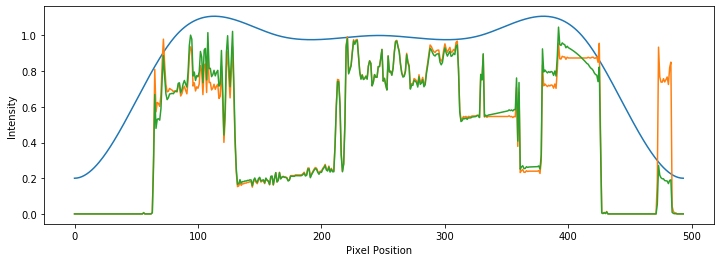

In [4]:
fig, (ax_prof) = plt.subplots(1, 1, figsize = (12,4))

ax_prof.plot(beam_img[beam_img.shape[0]//2], label = 'Beam Profile')
ax_prof.plot(cell_img[beam_img.shape[0]//2], label = 'Sample Image')
ax_prof.plot((cell_img*beam_img)[beam_img.shape[0]//2], label = 'Detector')
ax_prof.set_ylabel('Intensity')
ax_prof.set_xlabel('Pixel Position')
# make an interactive plot
import plotly.offline as py
import plotly.tools as tls
py.init_notebook_mode()
py.iplot(tls.mpl_to_plotly(fig))

Frequently there is a fall-off of the beam away from the center (as is the case of a Gaussian beam which frequently shows up for laser systems). This can make extracting detail away from the center challenging

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (8,8))
ax1.matshow(cell_img*beam_img, 
              cmap = 'viridis');

# Absorption Imaging (X-ray, Ultrasound, Optical)

#### For absorption/attenuation imaging $\rightarrow$ [Beer-Lambert Law](http://en.wikipedia.org/wiki/Attenuation_coefficient)
 $$ I_{detector} = \underbrace{I_{source}}_{I_{stimulus}}\underbrace{\exp(-\alpha d)}_{S_{sample}} $$

Different components have a different $\alpha$ based on the strength of the interaction between the light and the chemical / nuclear structure of the material

$$\begin{eqnarray}
I_{sample}(x,y) &=& I_{source}\exp(-\alpha(x,y) d) \\
\\
\alpha &=& f(N,Z,\sigma,\cdots)
\end{eqnarray}$$

#### For segmentation this model is: 
 - there are 2 (or more) distinct components that make up the image
 - these components are distinguishable by their values (or vectors, colors, tensors, ...)


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

I_source = 1.0
d = 1.0
alpha_1 = np.random.normal(1, 0.25, size = 100)
alpha_2 = np.random.normal(2, 0.25, size = 100)
alpha_3 = np.random.normal(3, 0.5, size = 100)

abs_df = pd.DataFrame([dict(alpha = c_x, material = c_mat) for c_vec, c_mat in zip([alpha_1, alpha_2, alpha_3], 
                       ['material 1', 'material 2', 'material 3']) for c_x in c_vec])
abs_df['I_detector'] = I_source*np.exp(-abs_df['alpha']*d)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12, 8))
for c_mat, c_df in abs_df.groupby('material'):
    ax1.scatter(x = c_df['alpha'], 
                y = c_df['I_detector'], 
                label = c_mat)
    ax3.hist(c_df['alpha'], alpha = 0.5, label = c_mat)
    ax2.hist(c_df['I_detector'],  alpha = 0.5, label = c_mat, orientation="horizontal")
ax1.set_xlabel('$\\alpha(x,y)$', fontsize = 15)
ax1.set_ylabel('$I_{detector}$', fontsize = 18)
ax1.legend()
ax2.legend()
ax3.legend(loc = 0)

ax4.axis('off');

# Example Mammography
Mammographic imaging is an area where model-based absorption imaging is problematic. Even if we assume a constant illumination (_rarely_ the case), 

$$\begin{eqnarray}
I_{detector} &=& \underbrace{I_{source}}_{I_{stimulus}}\underbrace{\exp(-\alpha d)}_{S_{sample}} \\
&\downarrow& \\
I_{detector} &=& \exp(-\alpha(x,y) d(x,y)) \\
&\downarrow& \\
I_{detector} &=& \exp\left(-\int_{0}^{l}\alpha(x,y, z) dz\right) 
\end{eqnarray}$$


Specifically the problem is related to the inability to separate the $\alpha$ and $d$ terms. 

We model a basic breast volume as a half sphere with a constant absorption factor:
$$\alpha(x,y,z) = 1e-2$$

$\rightarrow$ The $\int$ then turns into a $\Sigma$ in discrete space
- Air
- Breast tissue

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import ball

breast_mask = ball(50)[:,50:]

# just for 3d rendering, don't worry about it
import plotly.offline as py
from plotly.figure_factory import create_trisurf
py.init_notebook_mode()
from skimage.measure import marching_cubes_lewiner
vertices, simplices, _, _ = marching_cubes_lewiner(breast_mask>0)
x,y,z = zip(*vertices) 
fig = create_trisurf(x=x,
                        y=y, 
                        z=z, 
                        plot_edges=False,
                        simplices=simplices,
                        title="Breast Phantom")
py.iplot(fig)

ModuleNotFoundError: No module named 'plotly'

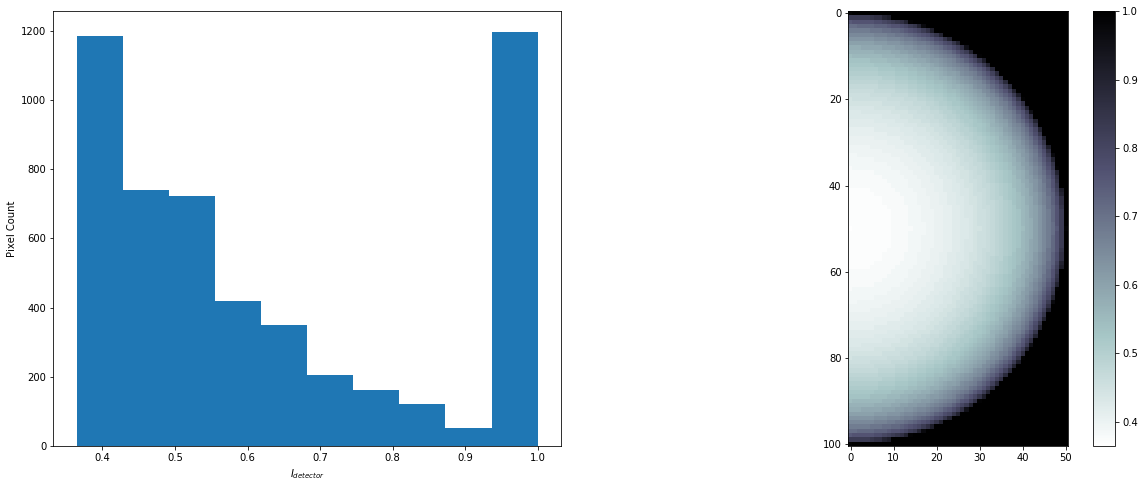

In [6]:
breast_alpha = 1e-2
breast_vol = breast_alpha*breast_mask
i_detector = np.exp(-np.sum(breast_vol,2))

fig, (ax_hist, ax_breast) = plt.subplots(1, 2, figsize = (20,8))

b_img_obj = ax_breast.imshow(i_detector, cmap = 'bone_r')
plt.colorbar(b_img_obj)

ax_hist.hist(i_detector.flatten())
ax_hist.set_xlabel('$I_{detector}$')
ax_hist.set_ylabel('Pixel Count');

If we know that $\alpha$ is constant we can reconstruct d from the image
$$ d = -\log(I_{detector})$$

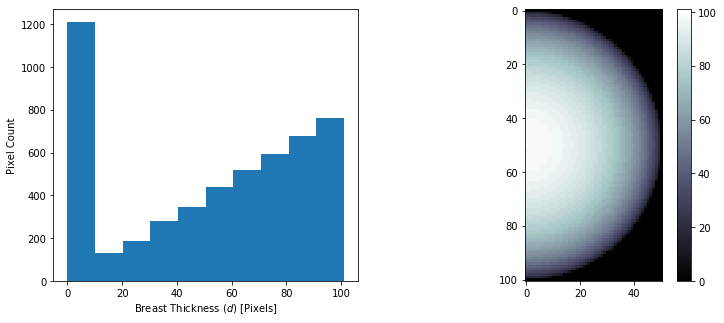

In [7]:
breast_thickness = -np.log(i_detector)/breast_alpha
fig, (ax_hist, ax_breast) = plt.subplots(1, 2, figsize = (12,5))

b_img_obj = ax_breast.imshow(breast_thickness, cmap = 'bone')
plt.colorbar(b_img_obj)

ax_hist.hist(breast_thickness.flatten())
ax_hist.set_xlabel('Breast Thickness ($d$) [Pixels]')
ax_hist.set_ylabel('Pixel Count');

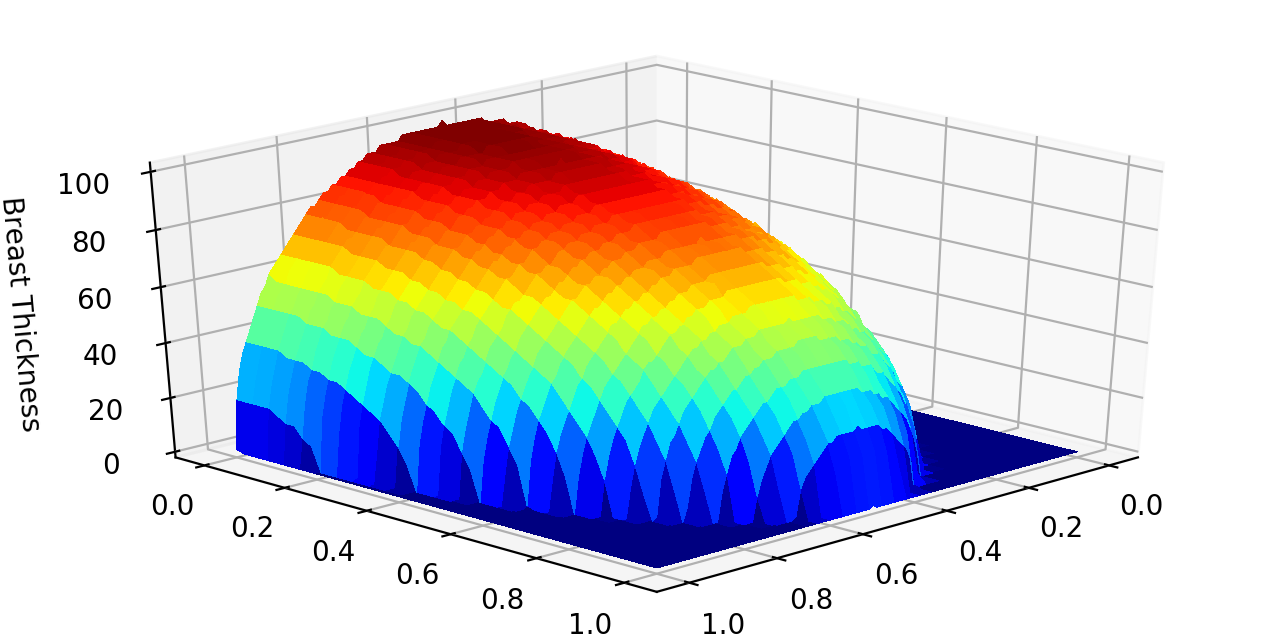

In [8]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8, 4), dpi = 200)
ax = fig.gca(projection='3d')
# Plot the surface.
yy, xx = np.meshgrid(np.linspace(0, 1, breast_thickness.shape[1]),
                       np.linspace(0, 1, breast_thickness.shape[0]))
surf = ax.plot_surface(xx, yy, breast_thickness, cmap=plt.cm.jet,
                       linewidth=0, antialiased=False)
ax.view_init(elev = 30, azim = 45)
ax.set_zlabel('Breast Thickness');

## What if $\alpha$ is not constant?
We run into problems when the $\alpha$ is no longer constant. 

- For example if we place a dark lump in the center of the breast. 

- It is __impossible__ to tell if the breast is _thicker_ or if the lump inside is _denser_. 

For the lump below we can see on the individual slices of the sample that the lesion appears quite clearly and is very strangely shaped.

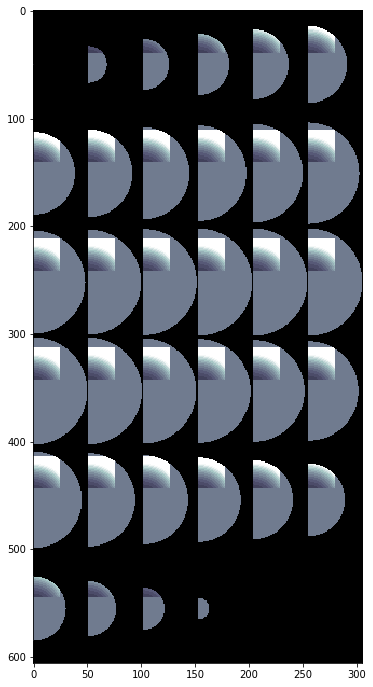

In [9]:
breast_vol = breast_alpha*breast_mask
renorm_slice = np.sum(breast_mask[10:40, 0:25], 2)/np.sum(breast_mask[30, 10])
breast_vol[10:40, 0:25] /= np.stack([renorm_slice]*breast_vol.shape[2],-1)

from skimage.util import montage as montage2d
fig, ax1 = plt.subplots(1,1, figsize = (12, 12))
ax1.imshow(montage2d(breast_vol.swapaxes(0,2).swapaxes(1,2)[::3]), 
           cmap = 'bone', vmin = breast_alpha*.8, vmax = breast_alpha*1.2)

When we make the projection and apply Beer's Law we see that it appears as a relatively constant region in the image

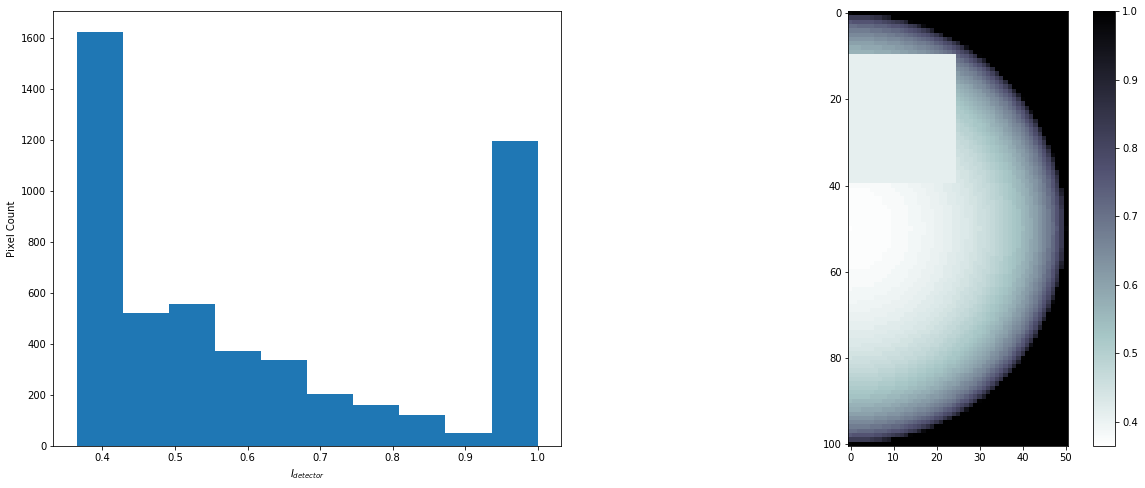

In [10]:
i_detector = np.exp(-np.sum(breast_vol,2))

fig, (ax_hist, ax_breast) = plt.subplots(1, 2, figsize = (20,8))

b_img_obj = ax_breast.imshow(i_detector, cmap = 'bone_r')
plt.colorbar(b_img_obj)

ax_hist.hist(i_detector.flatten())
ax_hist.set_xlabel('$I_{detector}$')
ax_hist.set_ylabel('Pixel Count');

## It appears as a flat constant region in the thickness reconstruction. 

So we fundamentally from this single image cannot answer:
- is the breast oddly shaped?
- or does it have an possible tumor inside of it?


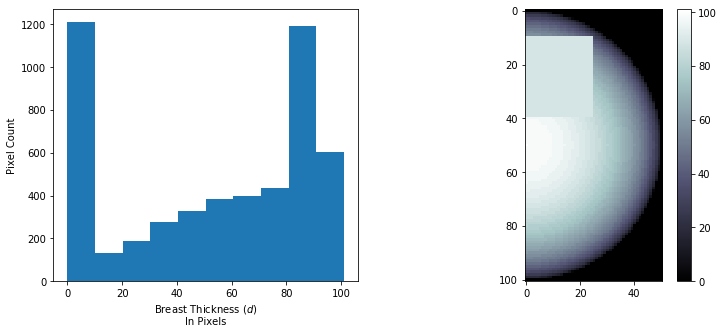

In [11]:
breast_thickness = -np.log(i_detector)/1e-2
fig, (ax_hist, ax_breast) = plt.subplots(1, 2, figsize = (12,5))

b_img_obj = ax_breast.imshow(breast_thickness, cmap = 'bone')
plt.colorbar(b_img_obj)

ax_hist.hist(breast_thickness.flatten())
ax_hist.set_xlabel('Breast Thickness ($d$)\nIn Pixels')
ax_hist.set_ylabel('Pixel Count');

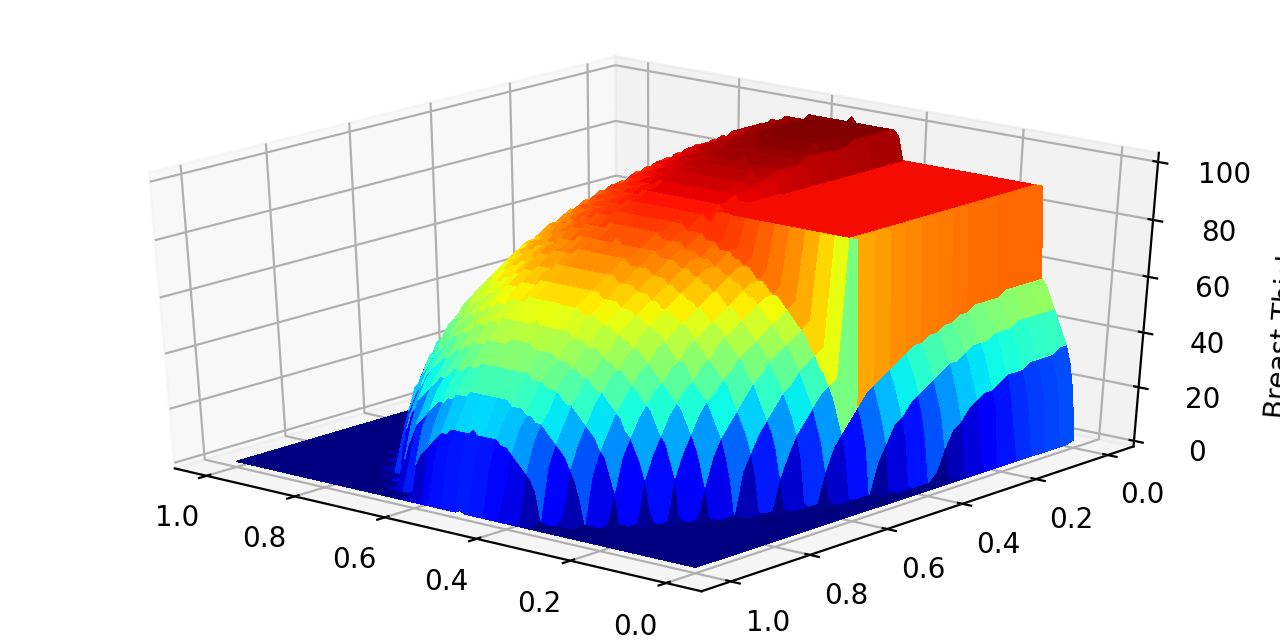

In [12]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (8, 4), dpi = 200)
ax = fig.gca(projection='3d')
# Plot the surface.
yy, xx = np.meshgrid(np.linspace(0, 1, breast_thickness.shape[1]),
                       np.linspace(0, 1, breast_thickness.shape[0]))
surf = ax.plot_surface(xx, yy, breast_thickness, cmap=plt.cm.jet,
                       linewidth=0, antialiased=False)
ax.view_init(elev = 30, azim = 130)
ax.set_zlabel('Breast Thickness');

# Where does segmentation get us?


We convert a decimal value or something even more complicated like 
- 3 values for RGB images,
- a spectrum for hyperspectral imaging, 
- or a vector / tensor in a mechanical stress field

To a single, discrete value: 
- usually true or false, 
- but for images with phases it would be each phase, e.g. bone, air, cellular tissue.

__2560 x 2560 x 2160 x 32 bit = 56GB / sample__ $\rightarrow$ 2560 x 2560 x 2160 x **1 bit** = 1.75GB / sample


# Basic segmentation: Applying a threshold to an image
Start out with a simple image of a cross with added noise
$$ I(x,y) = f(x,y) $$

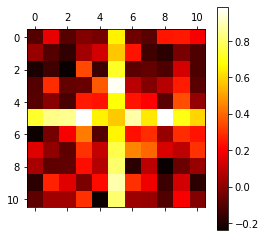

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

nx = 5
ny = 5
xx, yy = np.meshgrid(np.arange(-nx, nx+1)/nx*2*np.pi, 
                      np.arange(-ny, ny+1)/ny*2*np.pi)
cross_im = 1.5*np.abs(np.cos(xx*yy))/(np.abs(xx*yy)+(3*np.pi/nx))+np.random.uniform(-0.25, 0.25, size = xx.shape)
plt.matshow(cross_im, cmap = 'hot')
plt.colorbar()

The intensity can be described with a probability density function 
$$ P_f(x,y) $$

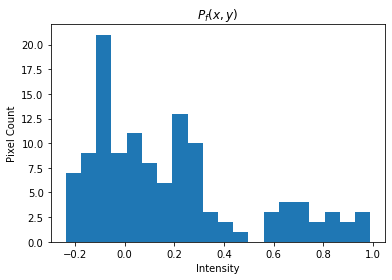

In [14]:
fig, ax1 = plt.subplots(1,1)
ax1.hist(cross_im.ravel(), 20)
ax1.set_title('$P_f(x,y)$') 
ax1.set_xlabel('Intensity')
ax1.set_ylabel('Pixel Count');

# Applying a threshold to an image

By examining the image and probability distribution function, we can _deduce_ that the underyling model is a whitish phase that makes up the cross and the darkish background

Applying the threshold is a deceptively simple operation

$$ I(x,y) = 
\begin{cases}
1, & f(x,y)\geq0.40 \\
0, & f(x,y)<0.40
\end{cases}$$

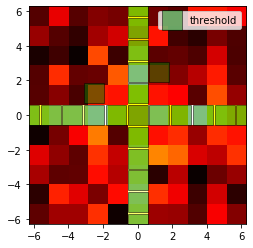

In [15]:
threshold = 0.4
fig, ax1 = plt.subplots(1,1)
ax1.imshow(cross_im, cmap = 'hot', extent = [xx.min(), xx.max(), yy.min(), yy.max()])
thresh_img = cross_im > threshold

ax1.plot(xx[np.where(thresh_img)], 
        yy[np.where(thresh_img)],
         'ks',
           markerfacecolor = 'green',
           alpha = 0.5,
         label = 'threshold',
         markersize = 20
           )
ax1.legend();

# Various Thresholds
We can see the effect of choosing various thresholds 


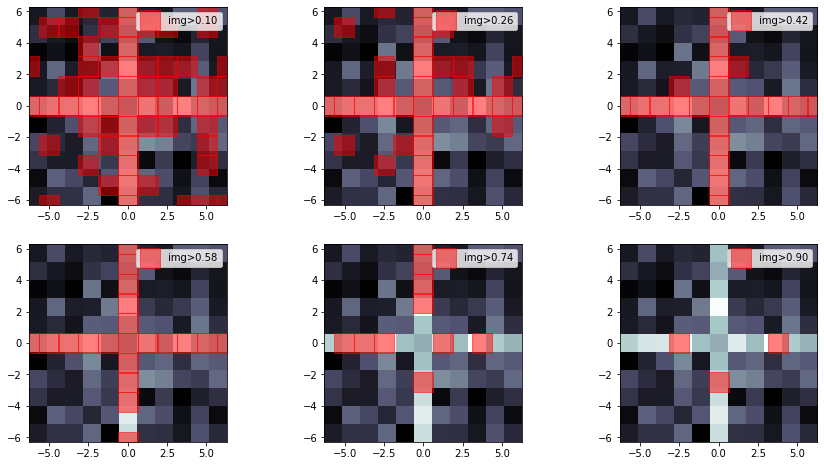

In [16]:
fig, m_axs = plt.subplots(2,3, 
                          figsize = (15, 8))
for c_thresh, ax1 in zip(np.linspace(0.1, 0.9, 6), m_axs.flatten()):
    
    ax1.imshow(cross_im,
               cmap = 'bone', 
               extent = [xx.min(), xx.max(), yy.min(), yy.max()])
    thresh_img = cross_im > c_thresh

    ax1.plot(xx[np.where(thresh_img)], yy[np.where(thresh_img)], 'rs', alpha = 0.5, label = 'img>%2.2f' % c_thresh, markersize = 20)
    ax1.legend(loc = 1);

# Segmenting Cells

- We can peform the same sort of analysis with this image of cells
- This time we can derive the model from the basic physics of the system
 - The field is illuminated by white light of nearly uniform brightness
 - Cells absorb light causing darker regions to appear in the image
 - _Lighter_ regions have no cells
 - __Darker__ regions have cells

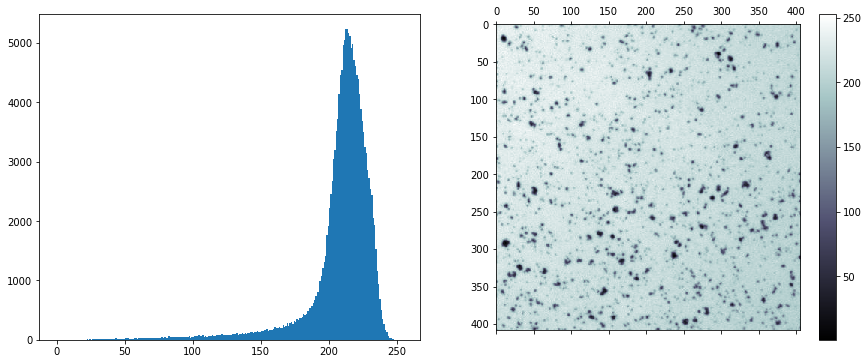

In [17]:
%matplotlib inline
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import numpy as np
cell_img = rgb2gray(imread("../common/figures/Cell_Colony.jpg"))
fig, (ax_hist, ax_img) = plt.subplots(1, 2, figsize = (15,6))
ax_hist.hist(cell_img.ravel(), np.arange(255))
ax_obj = ax_img.matshow(cell_img, cmap = 'bone')
plt.colorbar(ax_obj);

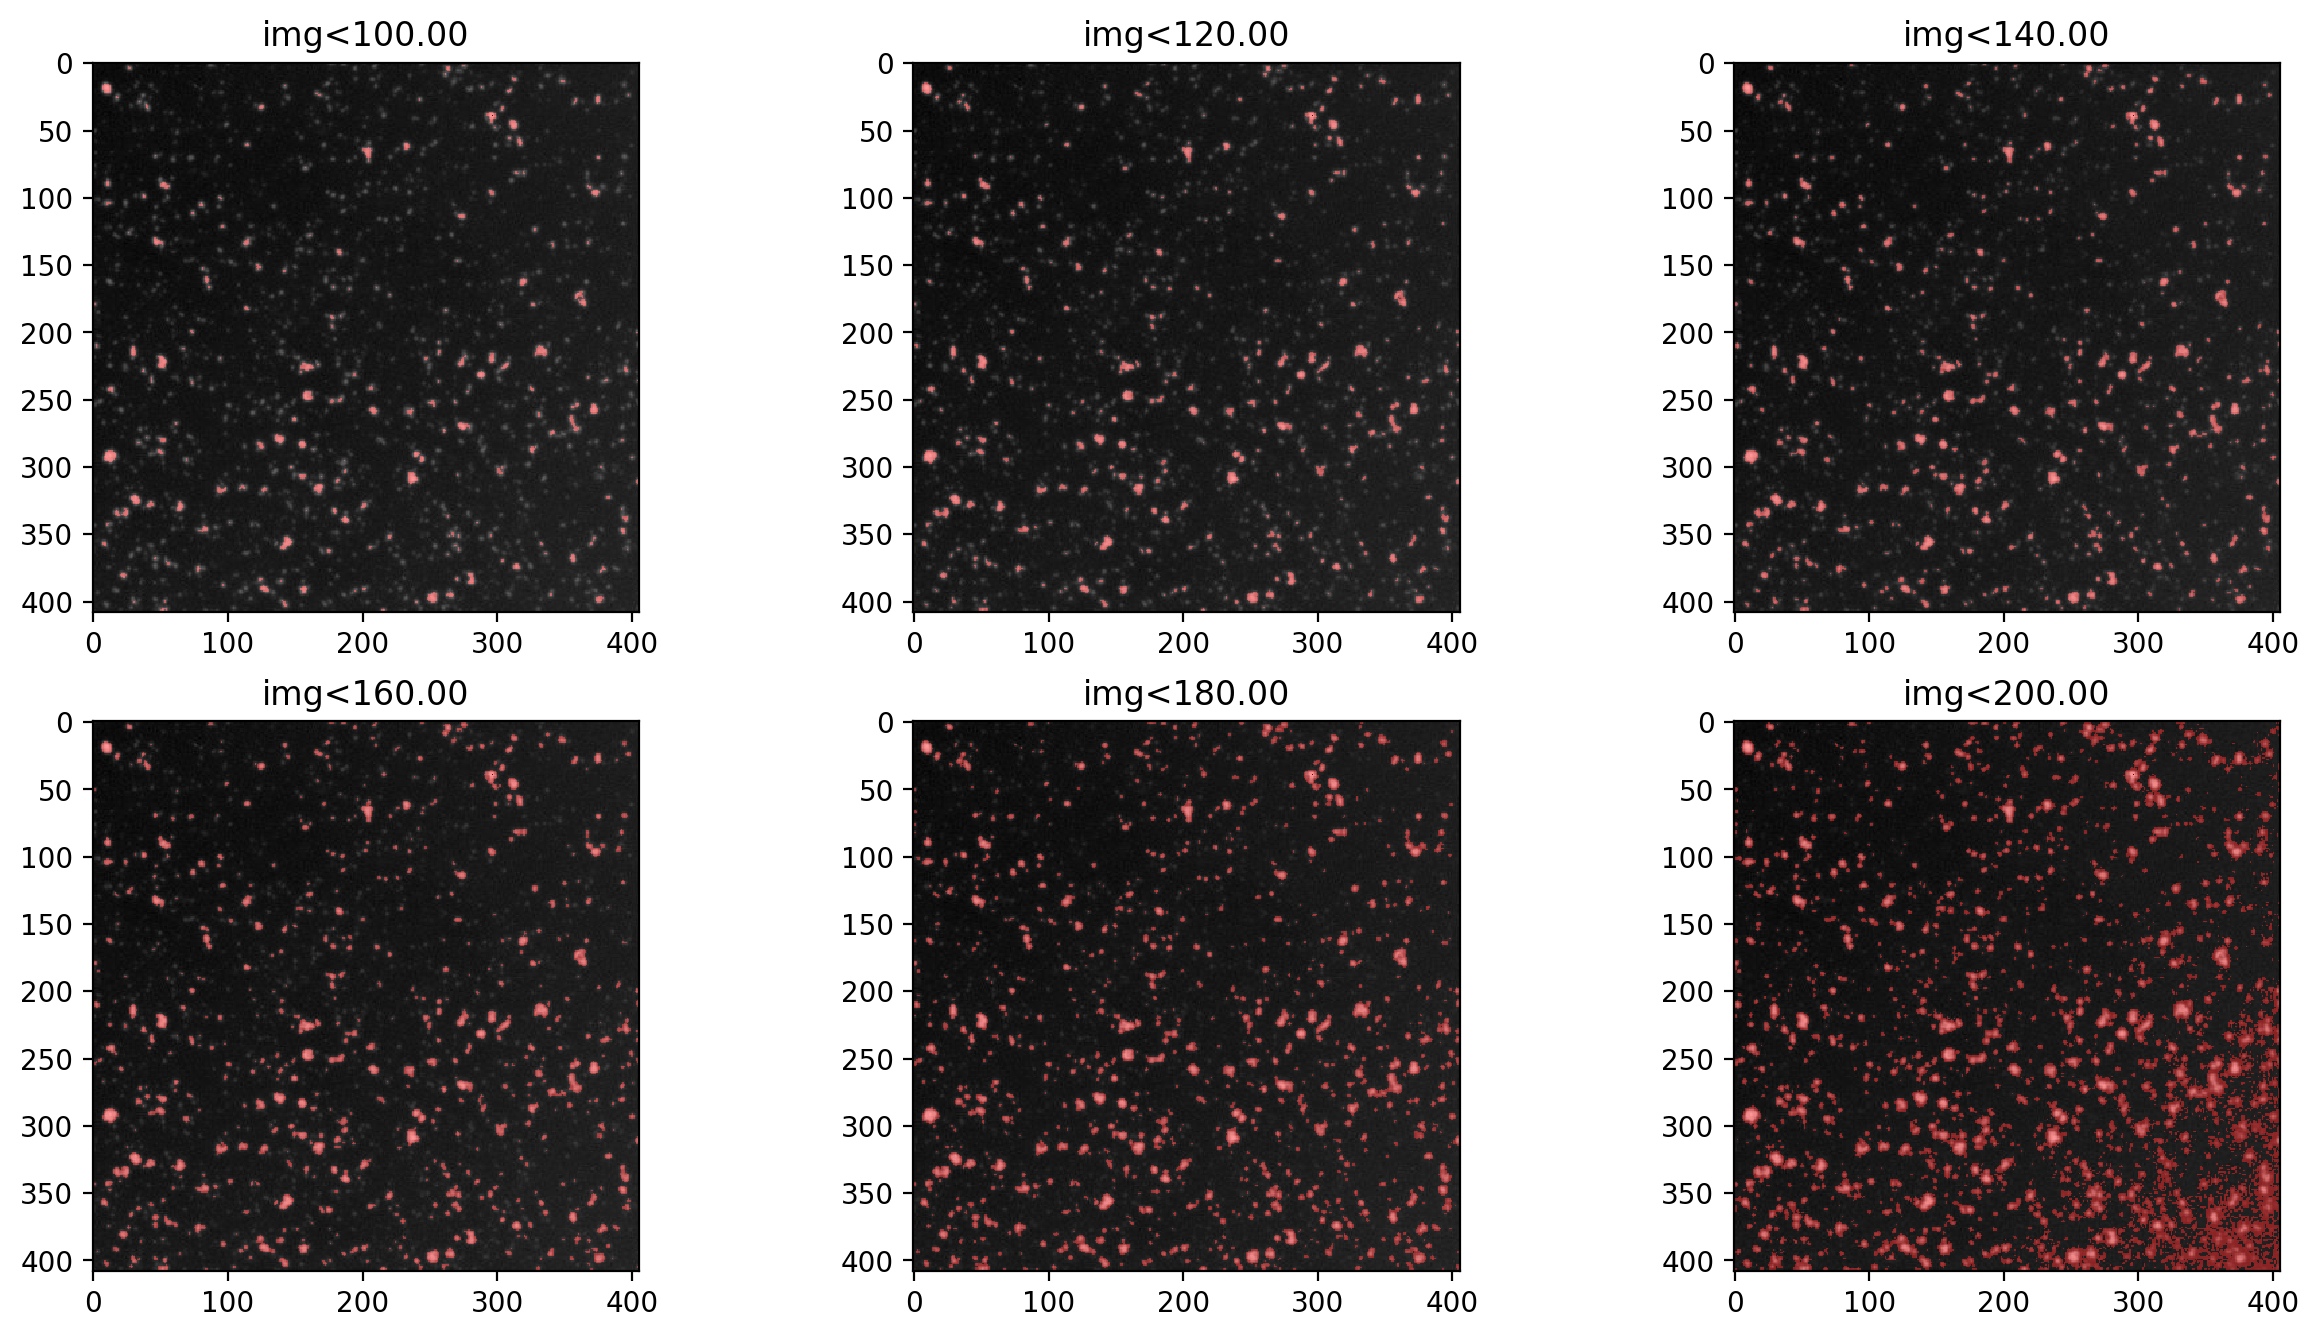

In [18]:
from skimage.color import label2rgb
fig, m_axs = plt.subplots(2,3, 
                          figsize = (15, 8), dpi = 200)
for c_thresh, ax1 in zip(np.linspace(100, 200, 6), 
                         m_axs.flatten()):
    thresh_img = cell_img < c_thresh

    ax1.imshow(label2rgb(thresh_img, image = 1-cell_img, bg_label = 0, alpha = 0.4))
    
    ax1.set_title('img<%2.2f' % c_thresh)

# Other Image Types

While scalar images are easiest, it is possible for any type of image
$$ I(x,y) = \vec{f}(x,y) $$

In [19]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

nx = 10
ny = 10
xx, yy = np.meshgrid(np.linspace(-2*np.pi, 2*np.pi, nx), 
                      np.linspace(-2*np.pi, 2*np.pi, ny))

intensity_img = 1.5*np.abs(np.cos(xx*yy))/(np.abs(xx*yy)+(3*np.pi/nx))+np.random.uniform(-0.25, 0.25, size = xx.shape)

base_df = pd.DataFrame(dict(x = xx.ravel(), 
                            y = yy.ravel(), 
                            I_detector = intensity_img.ravel()))

base_df['x_vec'] = base_df.apply(lambda c_row: c_row['x']/np.sqrt(1e-2+np.square(c_row['x'])+np.square(c_row['y'])), 1)
base_df['y_vec'] = base_df.apply(lambda c_row: c_row['y']/np.sqrt(1e-2+np.square(c_row['x'])+np.square(c_row['y'])), 1)

base_df.head(5)

,x,y,I_detector,x_vec,y_vec
0,-6.283185,-6.283185,0.098916,-0.707062,-0.707062
1,-4.886922,-6.283185,0.060947,-0.613892,-0.789290
2,-3.490659,-6.283185,-0.156931,-0.485596,-0.874073
3,-2.094395,-6.283185,0.279354,-0.316192,-0.948575
4,-0.698132,-6.283185,-0.157468,-0.110418,-0.993759


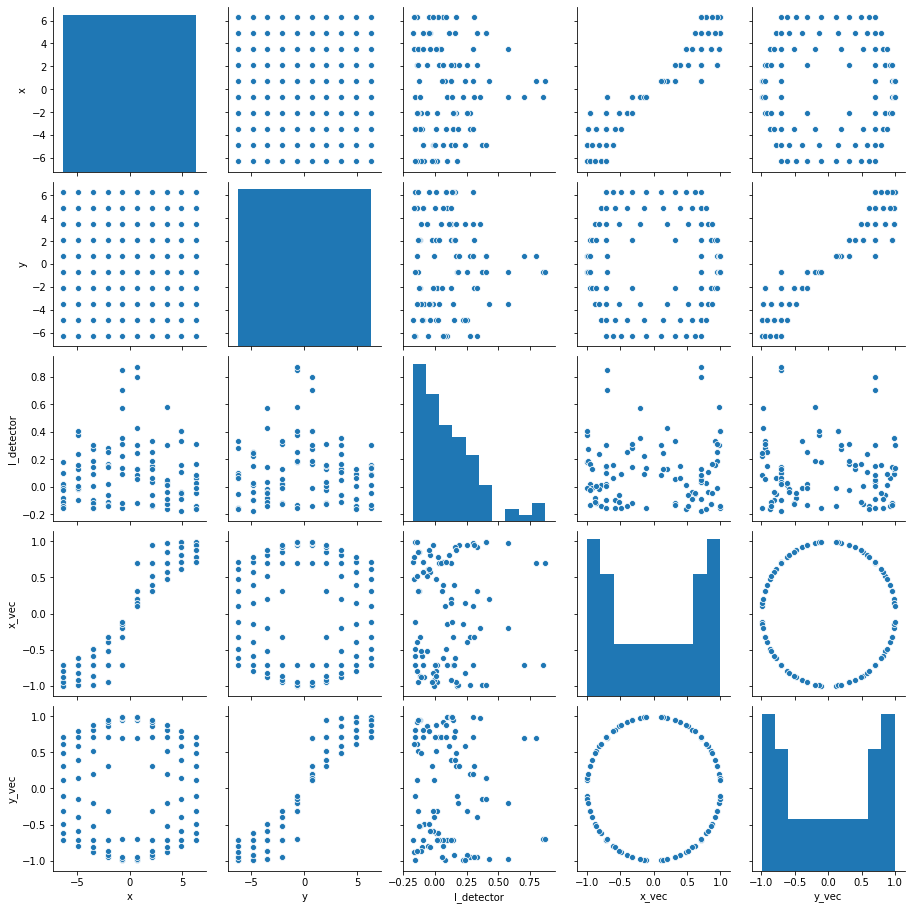

In [20]:
import seaborn as sns
sns.pairplot(base_df)

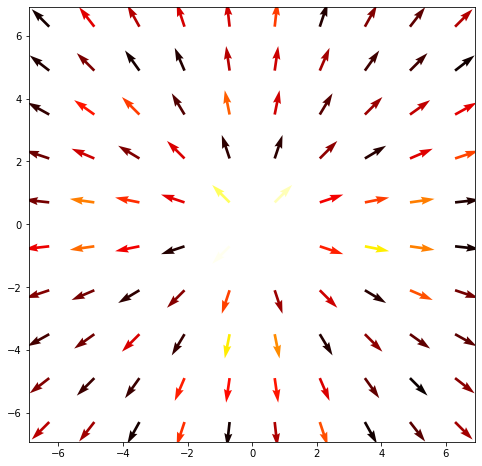

In [21]:
fig, ax1 = plt.subplots(1,1, figsize = (8, 8))
ax1.quiver(base_df['x'], base_df['y'], base_df['x_vec'], base_df['y_vec'], base_df['I_detector'], cmap = 'hot');

# Applying a threshold

A threshold is now more difficult to apply since there are now two distinct variables to deal with. The standard approach can be applied to both
$$ I(x,y) = 
\begin{cases}
1, & \vec{f}_x(x,y) \geq0.25 \text{ and}\\
& \vec{f}_y(x,y) \geq0.25 \\
0, & \text{otherwise}
\end{cases}$$

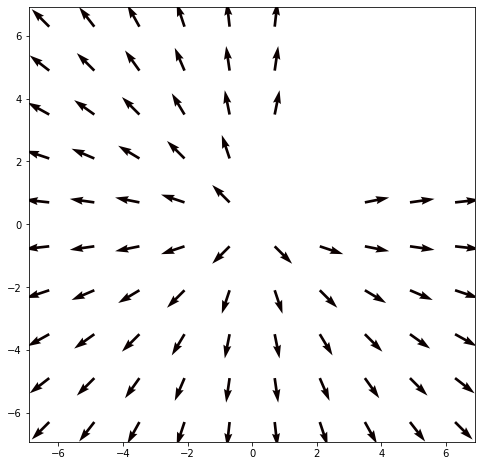

In [22]:
thresh_df = base_df.copy()
thresh_df['thresh'] = thresh_df.apply(lambda c_row: c_row['x_vec']>0.25 and c_row['y_vec']>0.25, 1)

fig, ax1 = plt.subplots(1,1, figsize = (8, 8))
ax1.quiver(thresh_df['x'], thresh_df['y'], thresh_df['x_vec'], thresh_df['y_vec'], thresh_df['thresh'], cmap = 'hot');

This can also be shown on the joint probability distribution as 

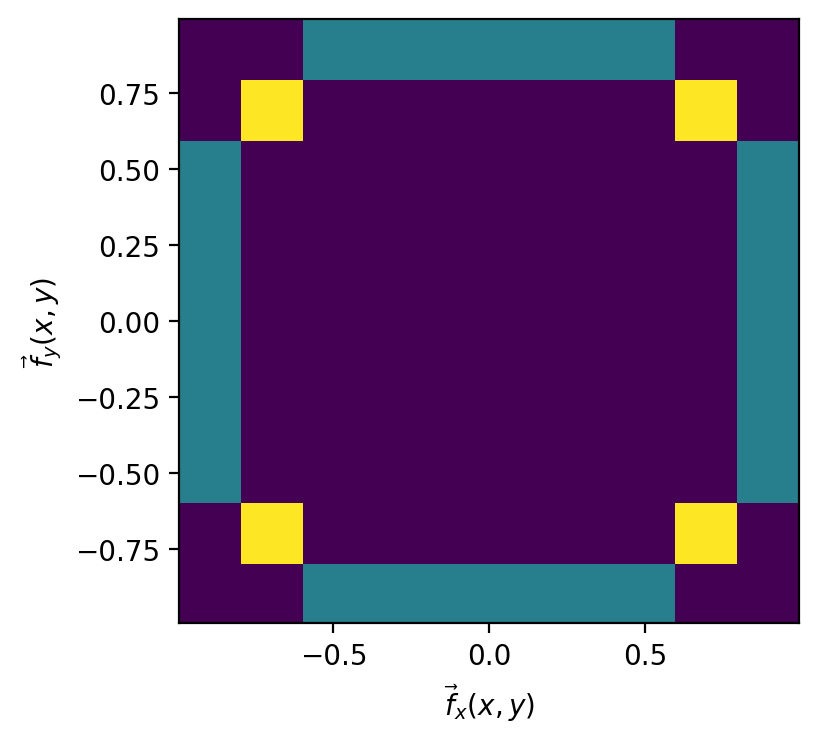

In [23]:
fig, ax1 = plt.subplots(1,1, figsize = (4, 4), dpi = 200)
ax1.hist2d(thresh_df['x_vec'], thresh_df['y_vec'], cmap = 'viridis');
ax1.set_xlabel('$\\vec{f}_x(x,y)$')
ax1.set_ylabel('$\\vec{f}_y(x,y)$');

# Applying a threshold
Given the presence of two variables; however, more advanced approaches can also be investigated. For example we can keep only components parallel to the x axis by using the dot product.
$$ I(x,y) = 
\begin{cases}
1, & |\vec{f}(x,y)\cdot \vec{i}| = 1 \\
0, & \text{otherwise}
\end{cases}$$

# Looking at Orientations
We can tune the angular acceptance by using the fact $$\vec{x}\cdot\vec{y}=|\vec{x}| |\vec{y}| \cos(\theta_{x\rightarrow y}) $$
$$ I(x,y) = 
\begin{cases}
1, & \cos^{-1}(\vec{f}(x,y)\cdot \vec{i}) \leq \theta^{\circ} \\
0, & \text{otherwise}
\end{cases}$$